# NIRISS commissioning kernel-phase data analysis

This notebook walks through the analysis of NIRISS CLEARP kernel-phase data starting from uncal files and finishing with companion detection limits. Installation instructions are given at the top.

## Step 1: install and import libraries

In addition to the JWST Kpi3 pipeline, two extra libraries are required to run this notebook:
1. the JWST data reduction pipeline (https://github.com/spacetelescope/jwst),
2. Jens Kammerer's fouriever toolkit (https://github.com/kammerje/fouriever).

In the virtual environment where you installed the Kpi3Pipeline, do the following:
1. Install the JWST data reduction pipeline
```
python -m pip install jwst
```
2. clone fouriever into a directory of your choice
```
python -m pip install git+https://github.com/kammerje/fouriever.git
```

In [1]:
import os

# Set up CRDS environment variables (required for JWST data reduction pipeline)
# Optinally uncomment if your environment variables are not set
# os.environ['CRDS_PATH'] = 'crds_cache'
# os.environ['CRDS_SERVER_URL'] = 'https://jwst-crds.stsci.edu'

# Import JWST data reduction pipeline
from jwst.pipeline import Detector1Pipeline, Image2Pipeline

# Import kernel-phase pipeline from XARA
from jwst_kpi.calwebb_kpi3 import Kpi3Pipeline

# Import model fitting tools from fouriever
from fouriever import klcal, uvfit

## Step 2: run JWST stage 1 & 2 and KPI stage 3 pipelines

The ipc, the photom, and the resample step in the JWST stage 1 & 2 pipelines should be skipped for kernel-phase data, similar as for AMI data. The KPI stage 3 pipeline creates diagnostic plots for each pipeline step that are saved in the output directory of the pipeline. The KPI stage 3 pipeline saves the output into KPFITS files whose structure is outlined here: https://docs.google.com/document/d/1iBbcCYiq9J2PpLSr21-xB4AXP8X_6tSszxnHY1VDGXg/edit?usp=sharing.

The input data is the NIRISS commissioning data. It can be downloaded from MAST.
The `uncal` files are expected to be separated per target as shown below

_Note: The jwst pipeline logging was configured with a [`stpipe-log.cfg`](https://jwst-pipeline.readthedocs.io/en/latest/jwst/stpipe/user_logging.html#logging-configuration) file to show only WARNING level messages and above._

In [2]:
# Get the uncal (or calints) files
idirs = ['kerphase_testdata/NIRISS/J062802.01-663738.0/',
         'kerphase_testdata/NIRISS/TYC-8906-1660-1/',
         'kerphase_testdata/NIRISS/CPD-66-562/',
         'kerphase_testdata/NIRISS/CPD-67-607/']
files = []
for idir in idirs:
    #files += sorted([idir + f for f in os.listdir(idir) if f.endswith('_uncal.fits')])
    files += sorted([idir + f for f in os.listdir(idir) if f.endswith('_calints.fits')])

--> Running fix bad pixels step...
Found 108267 bad pixels (7.08%)


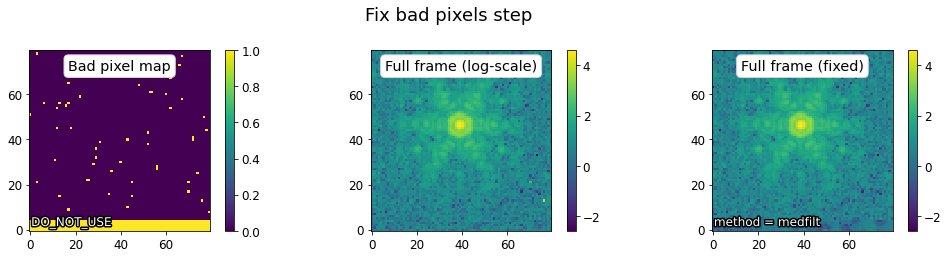

Done
--> Running extract kerphase step...
Trimming all frames to 68x68 pixels
Attempting to load file /Users/jkammerer/Documents/Code/jwst-kpi/jwst_kpi/pupil_data/niriss_clear_pupil.fits
KPI data successfully loaded
The file contains 0 data-sets
CWAVEL was not set
No covariance data available

First time for m2pix = 4.49: 
LDFT1: Computing new Fourier matrix...
Done!


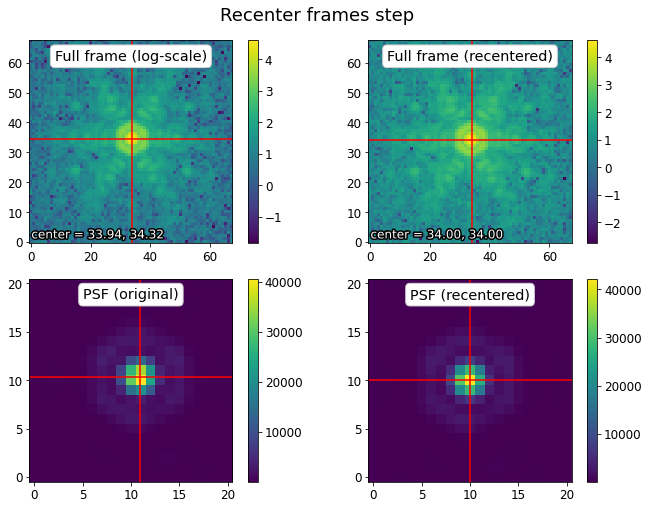

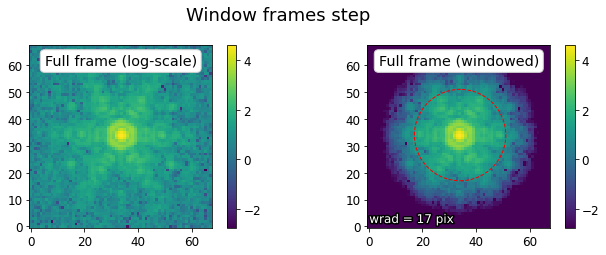

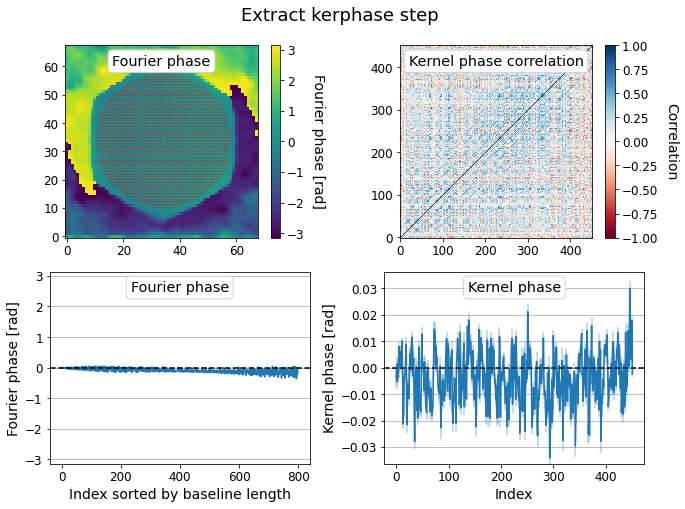

Done
<xara.kpo.KPO object at 0x174955330> deleted
<xara.kpi.KPI object at 0x1749552d0> deleted 
--> Running empirical uncertainties step...


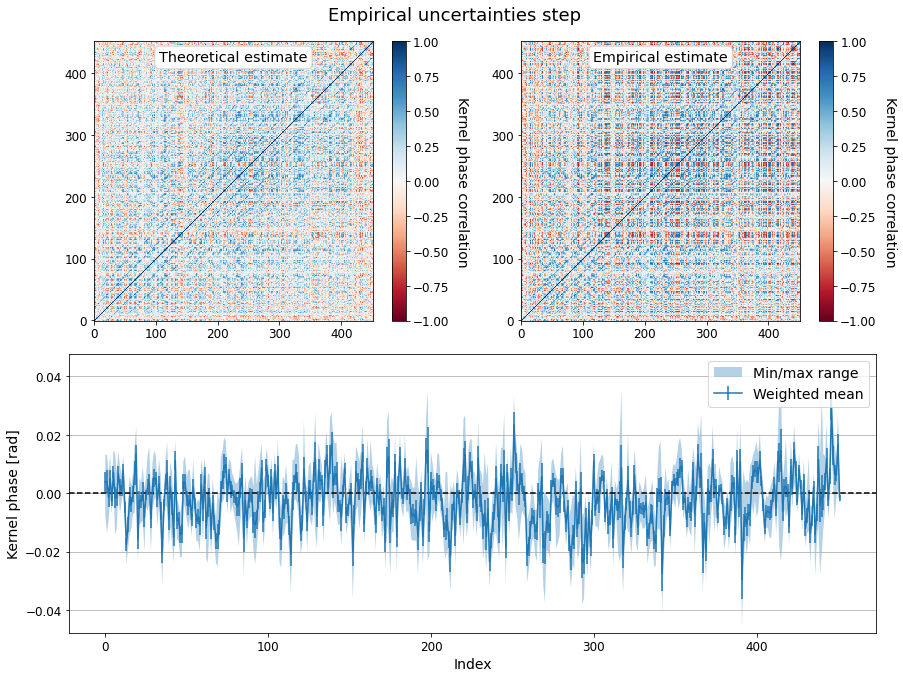

Done
--> Running fix bad pixels step...
Found 108267 bad pixels (7.08%)
Done
--> Running extract kerphase step...
Trimming all frames to 58x58 pixels
Attempting to load file /Users/jkammerer/Documents/Code/jwst-kpi/jwst_kpi/pupil_data/niriss_clear_pupil.fits
KPI data successfully loaded
The file contains 0 data-sets
CWAVEL was not set
No covariance data available

First time for m2pix = 3.83: 
LDFT1: Computing new Fourier matrix...
Done!
Done
<xara.kpo.KPO object at 0x1706b7400> deleted
<xara.kpi.KPI object at 0x1706b4490> deleted 
--> Running empirical uncertainties step...
Done
--> Running fix bad pixels step...
Found 106908 bad pixels (7.08%)
Done
--> Running extract kerphase step...
Trimming all frames to 68x68 pixels
Attempting to load file /Users/jkammerer/Documents/Code/jwst-kpi/jwst_kpi/pupil_data/niriss_clear_pupil.fits
KPI data successfully loaded
The file contains 0 data-sets
CWAVEL was not set
No covariance data available

First time for m2pix = 4.49: 
LDFT1: Computing new 

In [3]:
# Run each file through the pipelines (comment out stages 1 & 2 if using calints files)
show_plots = True
for file in files:

    output_dir = os.path.dirname(file) + os.sep
    """
    # Stage 1
    result1 = Detector1Pipeline()
    result1.save_results = True
    result1.output_dir = output_dir
    result1.ipc.skip = True
    result1.run(file)

    # Stage 2
    result2 = Image2Pipeline()
    result2.save_results = True
    result2.output_dir = output_dir
    result2.photom.skip = True
    result2.resample.skip = True
    result2.run(file.replace('uncal', 'rateints'))
    """
    # Stage 3
    result3 = Kpi3Pipeline()
    result3.output_dir = None  # output directory; if 'None', uses same directory as input data
    result3.show_plots = show_plots
    # Bad pixel fixing step
    result3.fix_bad_pixels.skip = False  # skip step?
    result3.fix_bad_pixels.plot = True  # make and save plots?
    result3.fix_bad_pixels.bad_bits = ['DO_NOT_USE']  # DQ flags to be considered as bad pixels (see https://jwst-reffiles.stsci.edu/source/data_quality.html)
    result3.fix_bad_pixels.method = 'medfilt'  # method to fix bad pixels; 'medfilt' or 'KI'
    # Re-centering step
    result3.recenter_frames.skip = False
    result3.recenter_frames.plot = True
    result3.recenter_frames.method = 'FPNM'  # XARA re-centering method; 'BCEN', 'COGI', or 'FPNM'
    result3.recenter_frames.crop = True
    result3.recenter_frames.bmax = 6.  # in m: maximum baseline length for FPNM re-centering method
    # Windowing step
    result3.window_frames.skip = False
    result3.window_frames.plot = True
    result3.window_frames.wrad = None  # in pix: radius of super-Gaussian window mask; if 'None', makes automatic guess
    # Kernel-phase extraction step
    result3.extract_kerphase.skip = False
    result3.extract_kerphase.plot = True
    result3.extract_kerphase.bmax = None  # m; maximum baseline length for kernel-phase extraction; if 'None', uses entire pupil model
    # Empirical uncertainties step
    result3.empirical_uncertainties.skip = False
    result3.empirical_uncertainties.plot = True
    result3.empirical_uncertainties.get_emp_err = True  # estimate uncertainties empirically from standard deviation over individual frames?
    # Run pipeline
    result3.run(file.replace('uncal', 'calints'))
    
    show_plots = False

## Step 3: determine contrast limits with fouriever

Fouriever can directly read the KPFITS files from the KPI stage 3 pipeline. The raw 1-sigma noise floor can be computed with the lincmap function in uvfit.

In [4]:
fouriever_raw_prefix = os.path.join(os.path.dirname(os.path.dirname(idirs[0])), "raw")

In [5]:
# Get the KPFITS files of J062802.01-663738.0
#fitsfiles = [f.replace('uncal', 'calints_emp_kpfits') for f in files[:2]]
fitsfiles = [f.replace('calints', 'calints_emp_kpfits') for f in files[:2]]

# Load the KPFITS files into fouriever
data = uvfit.data(idir='',
                  fitsfiles=fitsfiles)

# Compute 1-sigma noise floor
fit = data.lincmap(
    cov=False,  # account for data covariance in fit?
    sep_range=(30., 600.),  # mas; separation range of grid
    step_size=10.,  # mas; step size of grid
    smear=None,  # use bandwidth smearing?
    ofile=fouriever_raw_prefix,  # output file name
    save_as_fits=True
)  # save output as FITS file?
data.detlim(
    sigma=3.0,  # confidence level of detection limits
    fit_sub=None,  # best fit from MCMC
    cov=False,  # account for data covariance in fit?
    sep_range=(30., 600.),  # mas; separation range of grid
    step_size=40.,  # mas; step size of grid
    smear=None,  # use bandwidth smearing?
    ofile=fouriever_raw_prefix,
)  # output file name

Opened NIRISS data
   1 observations
   800 Fourier phases
   452 kernel phases
   1 wavelengths
Opened NIRISS data
   1 observations
   800 Fourier phases
   452 kernel phases
   1 wavelengths
Selected instrument = NIRISS
   Use self.set_inst(inst) to change the selected instrument
Selected observables = ['kp']
   Use self.set_observables(observables) to change the selected observables
Data properties
   Smallest spatial scale = 92.5 mas
   Largest spatial scale = 924.5 mas
   Using data covariance = False
Computing grid
   Min. sep. = 30.0 mas
   Max. sep. = 600.0 mas
   11264 non-empty grid cells
Computing linear contrast map (DO NOT TRUST UNCERTAINTIES)
   Cell 14641 of 14641
   Best fit companion flux = 0.644 +/- 0.000 %
   Best fit companion right ascension = 220.0 mas
   Best fit companion declination = -10.0 mas
   Best fit companion separation = 220.2 mas
   Best fit companion position angle = 92.6 deg
   Best fit red. chi2 = 4.764 (bin)
   Significance of companion = 7.9 sigm

In kernel-phase imaging (and AMI), the kernel-phase of the science target is usually calibrated with the kernel-phase of a point-source reference target. Fouriever can perform a Karhunen-Loeve calibration using the calibrate function in klcal. After calibrating the data, the calibrated 1-sigma noise floor can be computed.

In [6]:
# Output directory where the calibrated KPFITS files are saved
odir = os.path.join(os.path.dirname(os.path.dirname(idirs[0])), "cal/")

# Get the KPFITS files of CPD-66-562
#scifiles = [f.replace('uncal', 'calints_emp_kpfits') for f in files[4:6]]
scifiles = [f.replace('calints', 'calints_emp_kpfits') for f in files[4:6]]

# Get the KPFITS files of J062802.01-663738.0, TYC-8906-1660-1, and CPD-67-607
#calfiles = [f.replace('uncal', 'calints_emp_kpfits') for f in [*files[:4], *files[6:]]]
calfiles = [f.replace('calints', 'calints_emp_kpfits') for f in [*files[:4], *files[6:]]]

In [7]:
# Load the KPFITS files into fouriever
data = klcal.data(scidir='',
                  scifiles=scifiles,
                  caldir='',
                  calfiles=calfiles)

# Perform Karhunen-Loeve calibration
data.calibrate(odir=odir,
               K_klip=3)

Selected instrument = NIRISS
   Use self.set_inst(inst) to change the selected instrument
Selected observables = ['kp']
   Use self.set_observables(observables) to change the selected observables
Computing Karhunen-Loeve decomposition
   K_klip = 3
   kp: 6 data sets
   kp: projection matrix shape = (449, 452)
Computing Karhunen-Loeve projection
   File 2 of 2: kernel phase FITS file


If there appears to be a point source in the data, we can fit a binary model and sample its parameters with MCMC.

In [8]:
# Get the calibrated KPFITS files
fitsfiles = [f for f in os.listdir(odir) if f.endswith('emp_kpfits_klcal.fits')]
fouriever_cal_prefix = os.path.join(os.path.dirname(os.path.dirname(idirs[0])), "cal")

# Load the KPFITS files into fouriever
data = uvfit.data(idir=odir,
                  fitsfiles=fitsfiles)

Opened NIRISS data
   1 observations
   800 Fourier phases
   449 kernel phases
   1 wavelengths
Opened NIRISS data
   1 observations
   800 Fourier phases
   449 kernel phases
   1 wavelengths
Selected instrument = NIRISS
   Use self.set_inst(inst) to change the selected instrument
Selected observables = ['kp']
   Use self.set_observables(observables) to change the selected observables


In [9]:
fit = data.chi2map(
    model="bin",
    cov=False,
    sep_range=(30., 600.),
    step_size=40.,
    smear=None,
    ofile=fouriever_cal_prefix,
)

data.mcmc(fit=fit, temp=None, smear=None, ofile=fouriever_cal_prefix)

Data properties
   Smallest spatial scale = 92.5 mas
   Largest spatial scale = 924.5 mas
   Using data covariance = False
Computing grid
   Min. sep. = 40.0 mas
   Max. sep. = 600.0 mas
   708 non-empty grid cells
Computing chi-squared map (DO NOT TRUST UNCERTAINTIES)
   Cell 961 of 961
   690 unique minima found after 708 fits
   Optimal step size = 40.6 mas
   Current step size = 40.0 mas
   Best fit companion flux = 19.488 +/- 0.014 %
   Best fit companion right ascension = 144.1 +/- 0.3 mas
   Best fit companion declination = -44.7 +/- 0.4 mas
   Best fit companion separation = 150.9 +/- 0.3 mas
   Best fit companion position angle = 107.2 +/- 0.1 deg
   Best fit red. chi2 = 0.294 (bin)
   Significance of companion = 8.0 sigma
Computing best fit companion parameters (UNCERTAINTIES FROM MCMC)
   Using data covariance = False
   Covariance inflation factor = 0.294
   This may take a few minutes


2022-09-12 12:09:33,693 - stpipe - WARNING - You must install the tqdm library to use progress indicators with emcee


   Best fit companion flux = 19.489 +/- 0.037 %
   Best fit companion right ascension = 144.1 +/- 0.1 mas
   Best fit companion declination = -44.7 +/- 0.1 mas
   Best fit companion separation = 150.9 +/- 0.1 mas
   Best fit companion position angle = 107.2 +/- 0.0 deg
   Best fit red. chi2 = 0.294 (bin)
   Significance of companion = 8.0 sigma


{'model': 'bin',
 'p': array([  0.19489278, 144.12230861, -44.70161508]),
 'dp': array([0.00037262, 0.12130812, 0.09528223]),
 'chi2_red': 0.29402657873936394,
 'ndof': 898,
 'nsigma': 8.026957018033892,
 'smear': None,
 'cov': 'False'}

In [10]:
# Compute 3-sigma detection limits
data.detlim(
    sigma=3.0,  # confidence level of detection limits
    fit_sub=fit,  # best fit from MCMC
    cov=False,  # account for data covariance in fit?
    sep_range=(30., 600.),  # mas; separation range of grid
    step_size=40.,  # mas; step size of grid
    smear=None,  # use bandwidth smearing?
    ofile=fouriever_cal_prefix,
)

Subtracting bin model
Data properties
   Smallest spatial scale = 92.5 mas
   Largest spatial scale = 924.5 mas
   Using data covariance = False
Computing grid
   Min. sep. = 40.0 mas
   Max. sep. = 600.0 mas
   708 non-empty grid cells
Computing detection limits (3-sigma)
   Cell 961 of 961
